<a href="https://colab.research.google.com/github/gagan3012/staysafe/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import string
import os
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.autograd import Variable

In [2]:
!git clone https://github.com/Gunnika/Sign_Language_Detector-PyTorch.git

Cloning into 'Sign_Language_Detector-PyTorch'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 221 (delta 110), reused 147 (delta 46), pack-reused 0
Receiving objects: 100% (221/221), 36.69 MiB | 24.57 MiB/s, done.
Resolving deltas: 100% (110/110), done.


In [3]:
train_data_raw = pd.read_csv('/content/Sign_Language_Detector-PyTorch/Dataset/sign_mnist_train.csv', sep=",")
test_data_raw = pd.read_csv('/content/Sign_Language_Detector-PyTorch/Dataset/sign_mnist_test.csv', sep=",")

In [4]:
train_labels = train_data_raw['label']
train_data_raw.drop('label', axis=1, inplace=True) # dropping the label column

test_labels = test_data_raw['label']
test_data_raw.drop('label', axis=1, inplace=True) # dropping the label column

In [5]:

train_data = train_data_raw.values
train_labels = train_labels.values

test_data = test_data_raw.values
test_labels = test_labels.values

In [6]:
set(train_labels)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24}

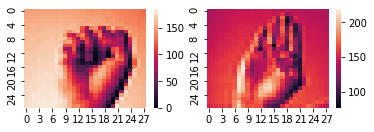

In [7]:
dim=28
pixels = train_data[20].reshape(dim, dim)
plt.subplot(221)
sns.heatmap(data=pixels)

pixels = train_data[30].reshape(dim, dim)
plt.subplot(222)
sns.heatmap(data=pixels)



In [8]:
reshaped_train = []
for i in train_data:
    reshaped_train.append(i.reshape(1, dim, dim))
train_data = np.array(reshaped_train)

reshaped_test = []
for i in test_data:
    reshaped_test.append(i.reshape(1, dim, dim))
test_data = np.array(reshaped_train)

In [9]:
train_x = torch.FloatTensor(train_data)
train_y = torch.LongTensor(train_labels.tolist())

test_x = torch.FloatTensor(train_data)
test_y = torch.LongTensor(train_labels.tolist())

In [10]:
alph = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',
        10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
        18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y' }

In [11]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,20,3)
        self.conv3 = nn.Conv2d(20,30,3)
        
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout2d(0.2)
        
        self.fc1 = nn.Linear(30*3*3, 270)
        self.fc2 = nn.Linear(270,26)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = x.view(-1, 30 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.softmax(F.relu(self.fc2(x)))
        
        return(x)

    def test(self, predictions,labels):
        self.eval()
        correct = 0
        for p,l in zip(predictions,labels):
            if p==l:
                correct+=1
        acc = correct/len(predictions)
        return(acc, correct, len(predictions))
    
    def evaluate(self, predictions,labels):
        correct = 0
        for p,l in zip(predictions,labels):
            if p==l:
                correct+=1
        acc = correct/len(predictions)
        return(acc)


In [12]:

use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    model = Network().cuda()


In [13]:
summary(model, (1,dim,dim)) #takes the model and the input tensor shape, displays the output shape


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
         MaxPool2d-2           [-1, 10, 13, 13]               0
            Conv2d-3           [-1, 20, 11, 11]           1,820
         MaxPool2d-4             [-1, 20, 5, 5]               0
            Conv2d-5             [-1, 30, 3, 3]           5,430
         Dropout2d-6             [-1, 30, 3, 3]               0
            Linear-7                  [-1, 270]          73,170
            Linear-8                   [-1, 26]           7,046
        LogSoftmax-9                   [-1, 26]               0
Total params: 87,566
Trainable params: 87,566
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.33
Estimated Total Size (MB): 0.43
---------------------------------------------

In [14]:
epochs = 1000
batch_size = 100
learning_rate = 0.001

In [15]:
optimizer = optim.SGD(model.parameters(), learning_rate, momentum=0.007)
criterion = nn.CrossEntropyLoss()

In [16]:
loss_log = []
acc_log = []

for e in range(epochs):
    for i in range(0, train_x.shape[0], 100):
        x_mini = train_x[i:i + 100] 
        y_mini = train_y[i:i + 100] 
        
        if use_cuda:
            x_mini = x_mini.cuda()
            y_mini = y_mini.cuda()
            test_x = test_x.cuda()
            test_y = test_y.cuda()
        
        optimizer.zero_grad()
        net_out = model(Variable(x_mini))
        
        loss = criterion(net_out, Variable(y_mini))
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 0:
            #pred = net(Variable(test_data_formated))
            loss_log.append(loss.item())
            acc_log.append(model.evaluate(torch.max(model(Variable(test_x[:500])).data, 1)[1], test_y[:500]))
        
    print('Epoch: {} - Loss: {:.6f}'.format(e + 1, loss.item()))

Epoch: 1 - Loss: 2.921319
Epoch: 2 - Loss: 2.519108
Epoch: 3 - Loss: 2.156399
Epoch: 4 - Loss: 1.894925
Epoch: 5 - Loss: 1.582812
Epoch: 6 - Loss: 1.188914
Epoch: 7 - Loss: 1.030612
Epoch: 8 - Loss: 0.954983
Epoch: 9 - Loss: 0.650663
Epoch: 10 - Loss: 0.491480
Epoch: 11 - Loss: 0.497054
Epoch: 12 - Loss: 0.400695
Epoch: 13 - Loss: 0.304431
Epoch: 14 - Loss: 0.228868
Epoch: 15 - Loss: 0.342148
Epoch: 16 - Loss: 0.276775
Epoch: 17 - Loss: 0.223621
Epoch: 18 - Loss: 0.191106
Epoch: 19 - Loss: 0.181141
Epoch: 20 - Loss: 0.125929
Epoch: 21 - Loss: 0.090046
Epoch: 22 - Loss: 0.076080
Epoch: 23 - Loss: 0.067296
Epoch: 24 - Loss: 0.076003
Epoch: 25 - Loss: 0.128165
Epoch: 26 - Loss: 0.099350
Epoch: 27 - Loss: 0.165166
Epoch: 28 - Loss: 0.052079
Epoch: 29 - Loss: 0.039427
Epoch: 30 - Loss: 0.044091
Epoch: 31 - Loss: 0.116696
Epoch: 32 - Loss: 0.115338
Epoch: 33 - Loss: 0.042534
Epoch: 34 - Loss: 0.256956
Epoch: 35 - Loss: 0.045306
Epoch: 36 - Loss: 0.052353
Epoch: 37 - Loss: 0.063782
Epoch: 38 

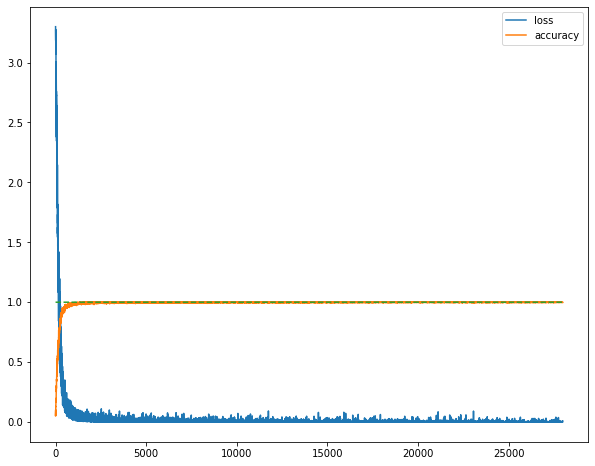

In [17]:
plt.figure(figsize=(10,8))
plt.plot(loss_log[2:])
plt.plot(acc_log)
plt.plot(np.ones(len(acc_log)), linestyle='dashed')
plt.legend(["loss","accuracy"])
plt.show()

In [18]:
predictions = model(Variable(test_x))
accuracy, correct, total = model.test(torch.max(predictions.data, 1)[1], test_y)

In [19]:
print("Accuracy = " + str(accuracy) + " ("+str(correct)+"/"+str(total)+")")

Accuracy = 0.9997814605718448 (27449/27455)


In [20]:
torch.save(model, 'model.pt')